![image.png](https://github.com/negrinij/NLP-AuthorsChallenge/blob/main/images/Spooky.png?raw=true)<br>
>*Code to create this WordCloud below in section 1.5 [Word Cloud](#1.5-Word-Cloud)<br>*

This notebook is an analysis of the Kaggle Hallowen challenge from 2017. The goal is to predict the author from a dataset built from excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft. 

## Contents
1. [Data Analysis](#1.-Data-Analysis)<br>
    1.1 [Analitycal Text Analysis](#1.1-Analitycal-Text-Analysis)<br>
    1.2 [Sentiment Analysis](#1.2-Sentiment-Analysis)<br>
    1.3 [Word Frequency](#1.3-Word-Frequency)<br>
    1.4 [Co-occurrence Word Pattern](#1.4-Co-occurrence-Word-Pattern)<br>
    1.5 [Word Cloud](#1.4-Word-Cloud)<br>
2. [NLP Model](#2.-NLP-Model)<br>
3. [Result and Conclusion](#3.-Result-and-Conclusion)<br>

***If you find this Notebook helpful, please remember to upvote !***

>Libraries

In [1]:
# initialize afinn sentiment analyzer
!pip install afinn
from afinn import Afinn
af = Afinn()

     |████████████████████████████████| 52 kB 415 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53449 sha256=30aa2b9773cfb7487d6f9a360c321f728d9ba5f4a0c30f2ebbf79bd571cf5282
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os,string,path

#wordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from urllib.request import urlopen
from PIL import Image

#Text Processing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

#ML Model
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import lightgbm as lgbm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

#Optimisation
import pickle
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) #Disable Warnings

>Functions

In [3]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 3),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False)  
    plt.title(plot_title, fontsize = 16,weight = 'bold')  

def preprocess_sentence(df): #returns the whole sentence, with preprocessed text
    word_list = []
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', df) #remove punctuations
    #text = text.lower() #lower case
    tokenized_word=word_tokenize(text) #separate into words
    for word in tokenized_word:
        if word not in stop_words: #filter stop-words
            word = stem.stem(word) #stemming
            word_list.append(word) #append to general list
    return ' '.join(word_list) #rejoins the sentence without the stopwords

def process_list(text): #returns a list of preprocessed words
        word_list = []
        #for t in text:            
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) #remove punctuations
        text = text.lower() #lower case
        tokenized_word=word_tokenize(text) #separate into words
        for word in tokenized_word:
            if word not in stop_words: #filter stop-words
                word = stem.stem(word) #stemming
                word_list.append(word) #append to general list
        return word_list
    
def build_freqs(texts, author):
    authorslist = np.squeeze(author).tolist()
    # Start with an empty dictionary and populate it by looping over all samples
    # and over all processed words in each sample.
    freqs = {}
    words_sample = []
    for text, author in zip(texts,authorslist):
        for word in process_list(text):
            words_sample.append(word)
            pair = (word, author)
            freqs[pair] = freqs.get(pair, 0) + 1  
    return freqs,words_sample

stop_words=set(stopwords.words("english"))
stem = PorterStemmer()

# 1. Data Analysis

In this section we will perform an overall analysis of the data. First, we analyse if there are any duplicates, missing entries or any need for data cleansing. Next, we start to create new features to understand the trends between the authors, such as: word count per sample, number of characters and so on. In the following section, we use the Affin Sentiment analysis library to see if there is any interesting pattern between the authors, perhaps one author has a more negative style of writing than the others. The Word Frequency of the individual authors and for the whole corpus is also performed. Finally, a Word Co-Occurrence analysis is presented. 

The analysis start below, by importing the training and test sets. A sample of the data is shown below:

In [4]:
df_train = pd.read_csv('/kaggle/input/spooky-author-identification/train.zip')
df_test = pd.read_csv('/kaggle/input/spooky-author-identification/test.zip')
pd.set_option('display.max_colwidth', None)
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [5]:
#Dictionary with Author names for more understandable Plots
author_dict = {
    'EAP': 'Edgar Allan Poe',
    'HPL': 'HP Lovecraft',
    'MWS': 'Mary Shelley'
}

From a basic EDA we conclude that there is no need for data cleansing, as there are no missing entries or duplicated values. The bar plot below shows the number of samples per author:

Number of Samples: 19579,
Number of Features: 3,
Duplicated Entries: 0,
Null Entries: 0,
Number of Rows with Null Entries: 0 0.0%


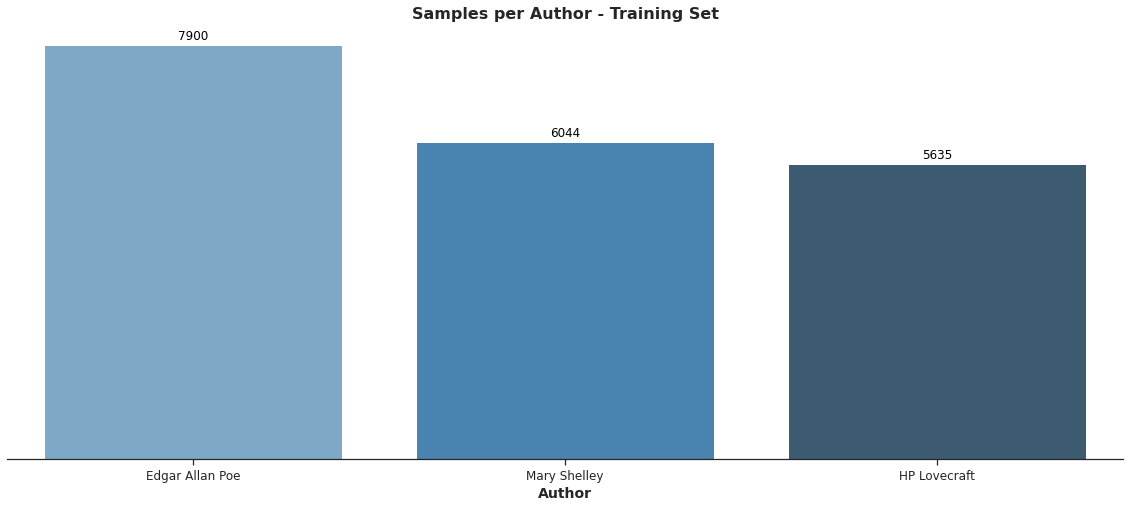

In [6]:
basic_EDA(df_train)
df_train['full_name'] = df_train['author'].map(author_dict.get) 
countplot(df_train, 'full_name', 'Author','Count', 'Samples per Author - Training Set')

* Edgar Allan Poe contains more samples if compared to the other two authors. However, the difference is not as critical as it would require any strategy for data unbalance for now
* In case the model shows a bias toward EAP, one could remove some samples or use strategies to generate additional samples for this author

## 1.1 Analitycal Text Analysis

In the analytical analysis, we create the following features: 

* Word Count - Total number of words in the sample
* Character Count - Total number of characters in the sample excluding spaces
* Word Density - Average length of the words used in the sample
* Punctuation Count - Total number of punctuations used in the sample
* Upper-Case to Lower-Case Words ratio - ratio of upper case words used and lower case words used in the text

In [7]:
punctuations = string.punctuation

def new_feat(df):
    df['word_count'] = df['text'].apply(lambda x : len(x.split()))
    df['char_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)

    #Adding +1 to allow ratio calculation
    df['Uppercase'] = df['text'].str.findall(r'[A-Z]').str.len()+1
    df['Lowercase'] = df['text'].str.findall(r'[a-z]').str.len()+1
    df['UppLowRatio'] = df['Uppercase'] / (df['Lowercase'] + 1)

    df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in punctuations]))
    
    return df

df_train_new = new_feat(df_train)
#df_test_new = new_feat(df_test)

A KDE plot can help us understand the pattern of the individual authors regarding the new features we created:

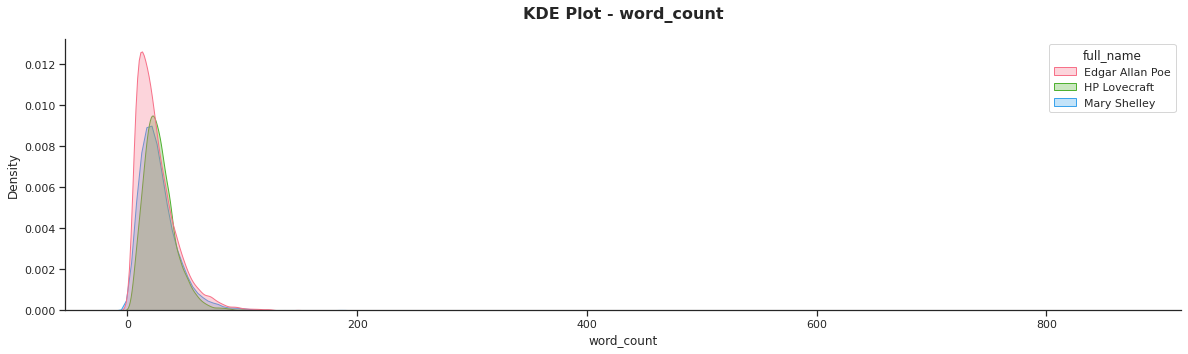

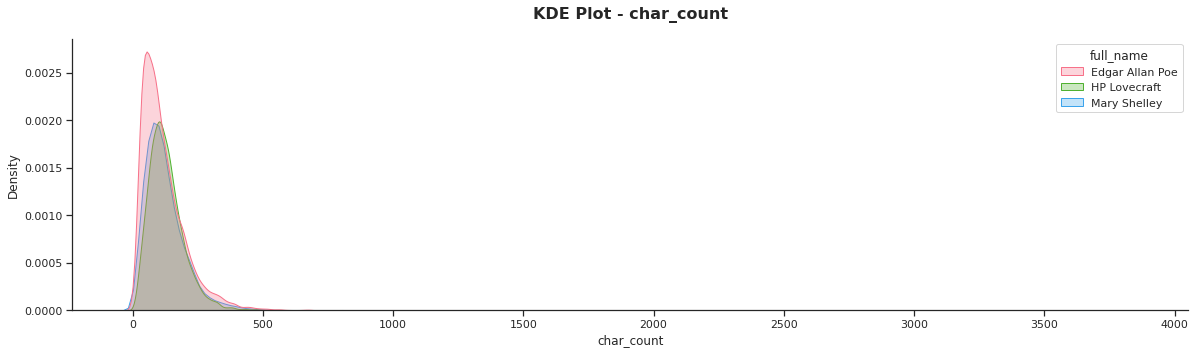

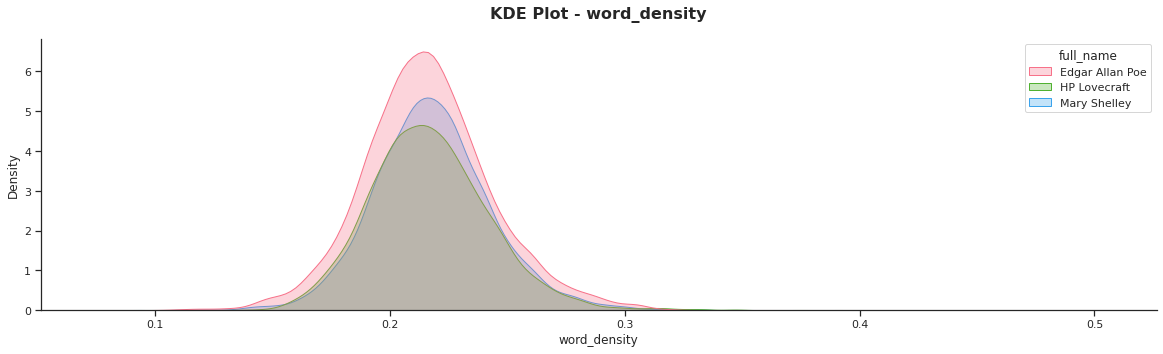

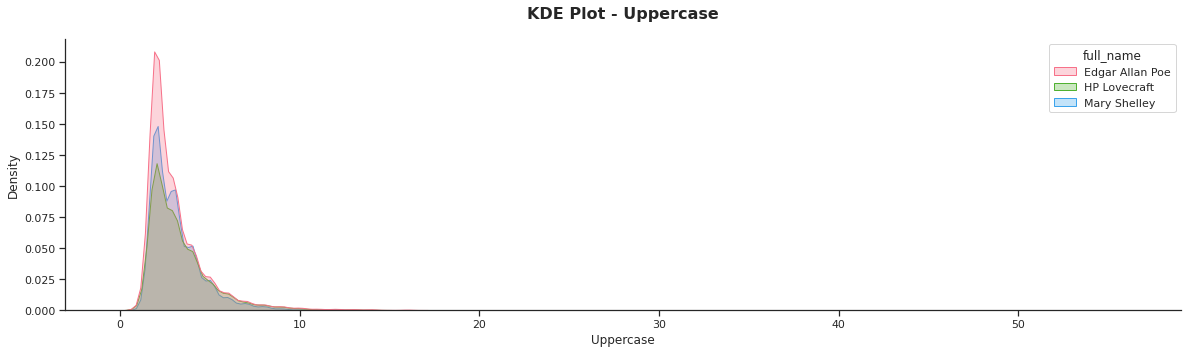

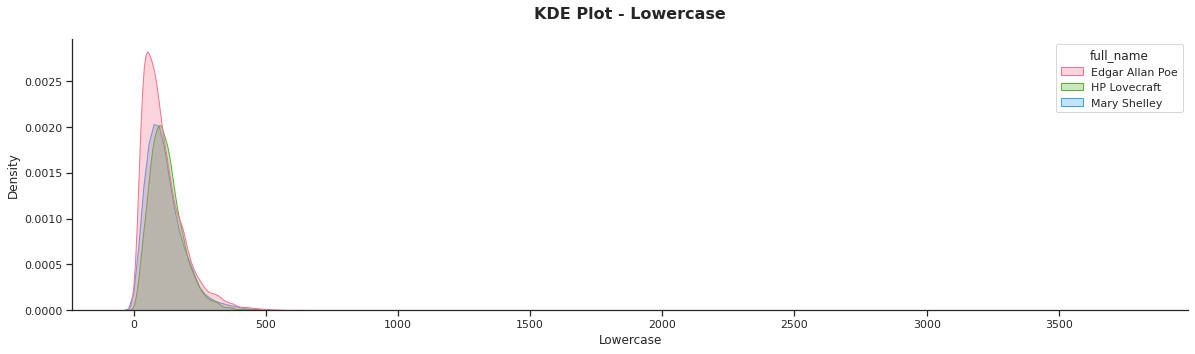

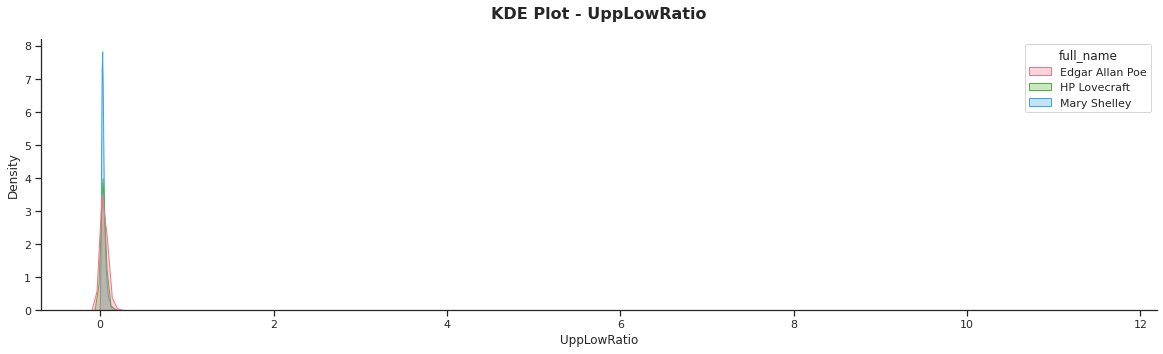

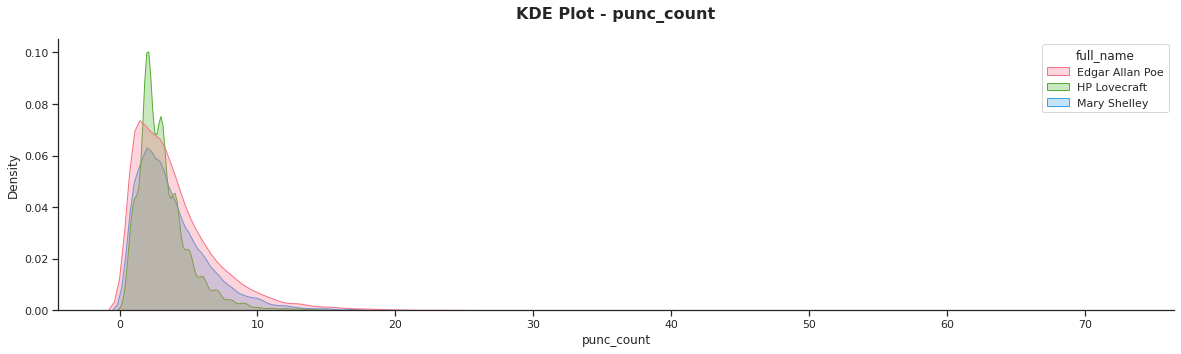

In [8]:
feat_list = ['word_count','char_count','word_density','Uppercase','Lowercase','UppLowRatio','punc_count']

for i in feat_list:
    plt.figure(figsize=(20,5))
    ax = sns.kdeplot(data = df_train_new, x = i, linewidth=1,alpha=.3, fill = True, hue = 'full_name',palette = 'husl') 
    ax.set_xlabel(i)
    plt.title('KDE Plot - ' + i, fontsize = 16,weight = 'bold',pad=20);  
    sns.despine(top=True, right=True, left=False, bottom=False)

* In a general manner, all authors have a similar distribution pattern 
* As EAP contains more samples, it usually presents higher density than the remaining authors on most analysis. However, for punctuation count, Upper and Lowercase Ratio it is surpassed by HP Lovecraft and Mary Shelley, respectively. It could mean that HP Lovecraft has a tendency for shorter sentences or more commas or semmi-colons than the other two. Regarding the Upper and Lower case ratio, it could be that Mary Shelley contains more characters or places that require Upper case when compared to EAP and HP.
* All, but the word_density plot, presents a positive skewed distribution, meaning outliers will present higher values than the mean

Now, let's visualise the outliers with a box-plot:

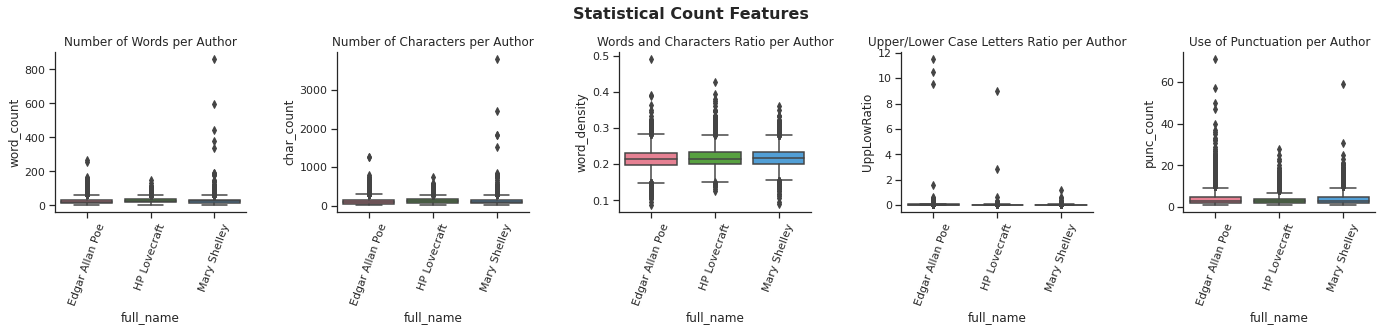

In [9]:
fig, axarr = plt.subplots(1,5, figsize=(20, 5))

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

feats = ['word_count','char_count','word_density','UppLowRatio','punc_count']
z = 0
for j in range(0,5):
    ax = sns.boxplot(data = df_train, x = 'full_name', y = df_train[feats[z]], ax=axarr[j],palette = 'husl');
    axarr[j].tick_params(axis='x', rotation=70)
    z +=1

axarr[0].set_title("Number of Words per Author")
axarr[1].set_title("Number of Characters per Author")
axarr[2].set_title("Words and Characters Ratio per Author")
axarr[3].set_title("Upper/Lower Case Letters Ratio per Author")
axarr[4].set_title("Use of Punctuation per Author")

fig.tight_layout(pad=3.0)
plt.suptitle('Statistical Count Features',fontsize=16, weight = 'bold');

plt.show()

* The median, upper and lower quartile of the authors are quite similar across the features
* Regarding the number of Words and Characters, (1st and 2nd plot), Mary Shelley presents more outliers with samples upto 800 words. Since the sentences have a lot of words, it is expected the same behaviour in the number of characters
* Note how Mary Shelley presents less outliers for Upper/Lower Case ratio than the other two authors, not surprisingly she presents the higher peak in the previous KDE plot for this same feature

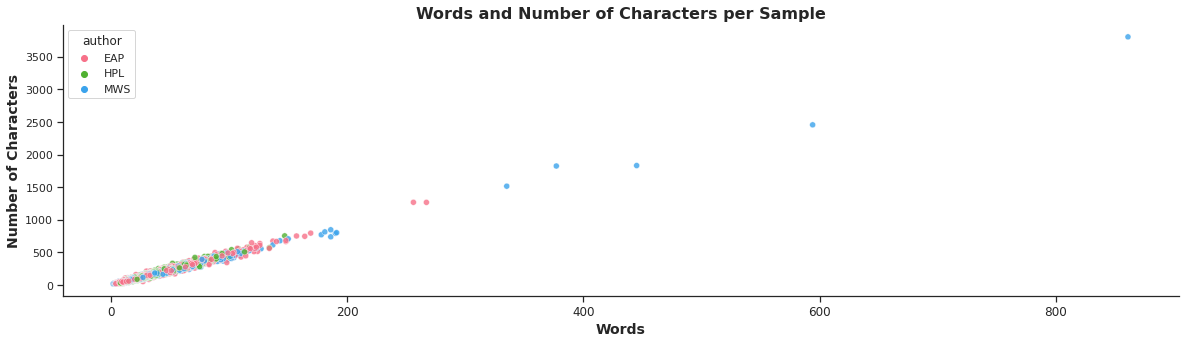

In [10]:
plt.figure(figsize=(20,5))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=df_train, x="word_count", y='char_count', hue = 'author',alpha=0.8, palette = 'husl');
#ax.set(xscale="log", yscale="log")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Words',fontsize = 14,weight = 'bold')
ax.set_ylabel('Number of Characters',fontsize = 14,weight = 'bold')
plt.title('Words and Number of Characters per Sample', fontsize = 16,weight = 'bold');

## 1.2 Sentiment Analysis

In this section we perform a sentiment analysis using AFFIN lexicon. See https://github.com/darenr/afinn for more info. AFINN is a list of words rated for *valence* with an integer between minus five (negative) and plus five (positive). Here, we are using AFINN-en-165. Basically, for every word of the samples, a value is assigned. After evaluating all the words of a sample, the final result has a positive or negative score, indicating the author intent. 

Clearly, this is a simplistic approach to evaluate the authors ideas. However, it can give us insights and it is also fun to see the algorithm results. 

Look at the result of some samples below, it does seem correct:

In [11]:
# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(text) for text in df_train['text']]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
sentiment_df = pd.DataFrame([list(df_train['text']), list(df_train['full_name']),sentiment_scores, sentiment_category]).T
sentiment_df.columns = ['text', 'author','score', 'sentiment_category']
sentiment_df['score'] = sentiment_df.score.astype('float')
sentiment_df.head()

,text,author,score,sentiment_category
0,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",Edgar Allan Poe,2.0,positive
1,It never once occurred to me that the fumbling might be a mere mistake.,HP Lovecraft,-2.0,negative
2,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",Edgar Allan Poe,8.0,positive
3,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",Mary Shelley,14.0,positive
4,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HP Lovecraft,-4.0,negative


Below is the sample with the most positive sentiment score. The score is computed by word, so longer samples will have higher scores. Something to keep in mind, and perhaps use some kind of normalisation for a more accurate result, but for this analysis it does no harm.

In [12]:
sentiment_df.loc[sentiment_df['score'].idxmax()]

text                  Oh no I will become wise I will study my own heart and there discovering as I may the spring of the virtues I possess I will teach others how to look for them in their own souls I will find whence arrises this unquenshable love of beauty I possess that seems the ruling star of my life I will learn how I may direct it aright and by what loving I may become more like that beauty which I adore And when I have traced the steps of the godlike feeling which ennobles me makes me that which I esteem myself to be then I will teach others if I gain but one proselyte if I can teach but one other mind what is the beauty which they ought to love and what is the sympathy to which they ought to aspire what is the true end of their being which must be the true end of that of all men then shall I be satisfied think I have done enough Farewell doubts painful meditation of evil the great, ever inexplicable cause of all that we see I am content to be ignorant of all this happy that n

Now the more negative sample found:

In [13]:
sentiment_df.loc[sentiment_df['score'].idxmin()]

text                  The dead were carried out, and the sick brought in, with like indifference; some were screaming with pain, others laughing from the influence of more terrible delirium; some were attended by weeping, despairing relations, others called aloud with thrilling tenderness or reproach on the friends who had deserted them, while the nurses went from bed to bed, incarnate images of despair, neglect, and death.
author                                                                                                                                                                                                                                                                                                                                                                                                                         Mary Shelley
score                                                                                                                                           

Next, let's count the number of positive, negative and neutral samples each author has:

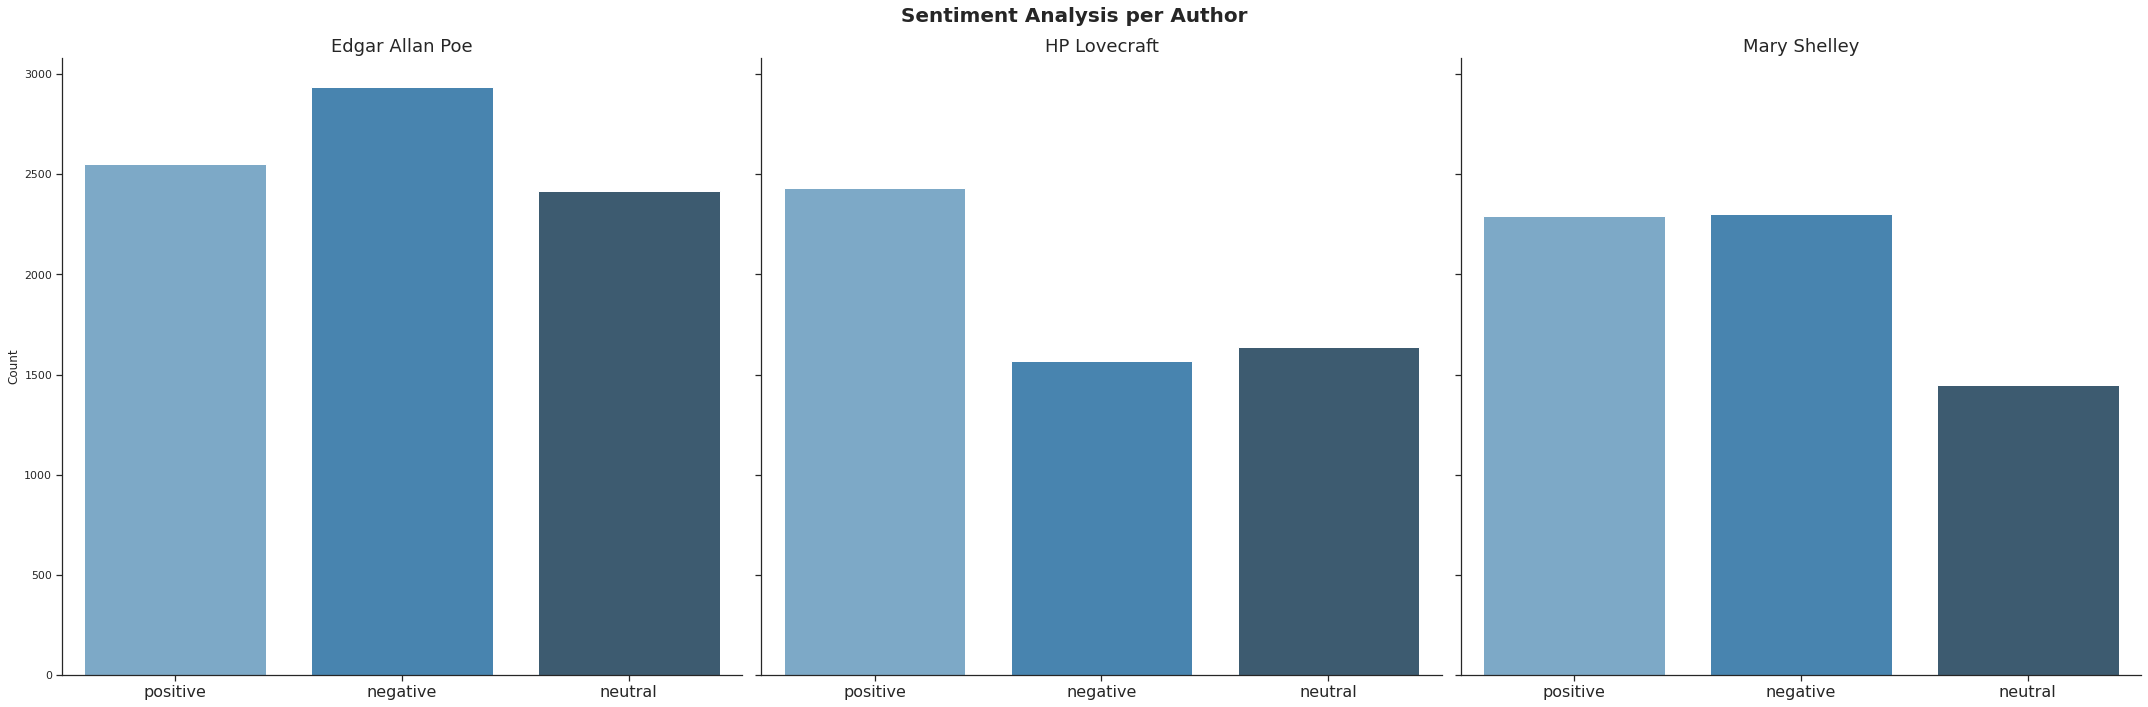

In [14]:
g = sns.FacetGrid(sentiment_df, col='author', height=10,col_wrap = 3)

g.map_dataframe(sns.countplot,data=sentiment_df, x='sentiment_category',palette="Blues_d")

g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 18)
g.set_xticklabels(rotation = 0, size = 16) 
g.fig.subplots_adjust(top=.5)
g.fig.suptitle('Sentiment Analysis per Author',fontsize=20, weight = 'bold')

axes = g.axes.flatten()
axes[0].set_ylabel('Count')

g.fig.tight_layout()

* All three authors contain a similar number of positive samples. It is interesting since Edgar Allan Poe represents 60% of the dataset but only a third of the positive samples
* Edgar Allan Poe has double the amount of negative samples compared to HP Lovecraft. Even though EAP has more samples overall, it is the only author where the negative samples surpass the positives
* Mary Shelley has a similar number of positive and negative entries. HP Lovecraft presents ~40% more positive samples than negative samples

A quick look at the outliers for the Sentiment Analysis is performed below using Box-Plot:

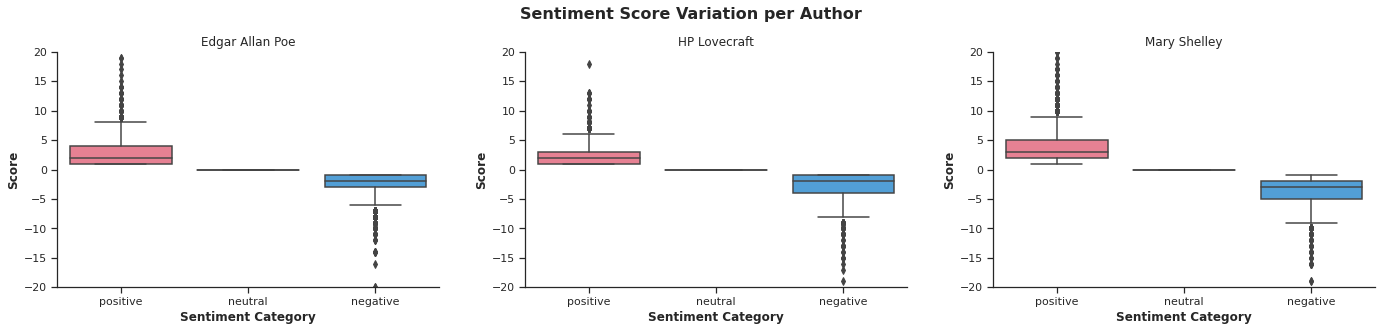

In [15]:
authors = list(author_dict.values())

fig, axarr = plt.subplots(1,3, figsize=(20, 5))

z = 0
for j in authors:
    df = sentiment_df[sentiment_df['author'] == j]
    ax = sns.boxplot(data = df, x = 'sentiment_category', y = 'score', ax=axarr[z],palette = 'husl', order=["positive", "neutral", "negative"])
    ax.set(ylim=(-20, 20))
    axarr[z].set_title(j)
    axarr[z].set_xlabel('Sentiment Category',fontsize = 12,weight = 'bold')
    axarr[z].set_ylabel('Score',fontsize = 12,weight = 'bold')
    z +=1

sns.despine(top=True, right=True, left=False, bottom=False)
fig.tight_layout(pad=3.0)
plt.suptitle('Sentiment Score Variation per Author',fontsize=16, weight = 'bold');

* Overall, all authors present a similar pattern for positive and negative samples (median and lower/upper quartiles)
* Most samples are within the values of 5 and -5
* Mary Shelley presents more extreme outliers, but the y-axis was limited to improve visualisation

## 1.3 Word Frequency By Author

Here we analyse the commonly used words according to each author. Common **Stop Words** are excluded, and stemming is performed. The result is shown in the plots below:

In [16]:
freqs_author, words = build_freqs(df_train['text'], df_train['author'])

freq_words = []

for word in words:
    MWS = 0
    HPL = 0
    EAP = 0
    if (word, 'MWS') in freqs_author:
        MWS = freqs_author[(word, 'MWS')]
    if (word, 'HPL') in freqs_author:
        HPL = freqs_author[(word, 'HPL')]
    if (word, 'EAP') in freqs_author:
        EAP = freqs_author[(word, 'EAP')]      
    freq_words.append([word, MWS,HPL,EAP])   

freq_wordsDF = pd.DataFrame(freq_words, columns = ['word', 'MWS','HPL','EAP'])    
freq_wordsDF['sum'] =  freq_wordsDF.loc[:, ['MWS','HPL','EAP']].sum(axis=1)
freq_wordsDF.sort_values('sum', ascending=False,inplace=True)
freq_wordsDF.drop_duplicates(inplace=True)

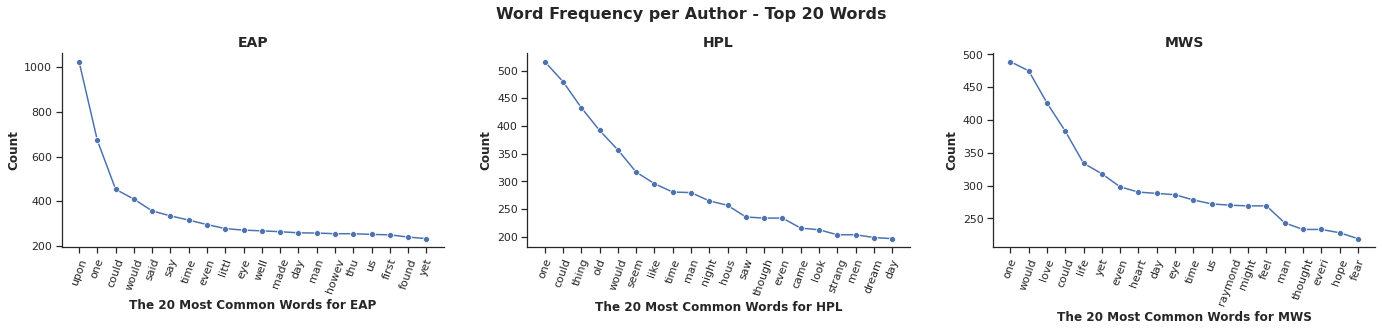

In [17]:
z = 0; j = 0
fig, axarr = plt.subplots(1,3, figsize=(20, 5))

authors_abbr = list(author_dict.keys())

for i in authors_abbr:
    df = freq_wordsDF.loc[:,['word',i]]
    df.sort_values(i, ascending=False,inplace=True)
    ax = sns.lineplot(data=df[0:20],x="word", y=i, marker='o',ax=axarr[z])
    axarr[z].tick_params(axis='x', rotation=70)    
    axarr[z].set_xlabel('The 20 Most Common Words for ' + i,fontsize = 12,weight = 'bold')
    axarr[z].set_ylabel('Count',fontsize = 12,weight = 'bold')
    axarr[z].set_title(i, fontsize = 14,weight = 'bold');
    sns.despine(top=True, right=True, left=False, bottom=False)
    z+=1
    #print(FreqDF[0:15]['word'])
    
fig.tight_layout(pad=3.0)
plt.suptitle('Word Frequency per Author - Top 20 Words',fontsize=16, weight = 'bold');
plt.show()

* Edgar Allan Poe contains more samples on this dataset, what explains (sort of) the impressive number of times the author uses the **upon** word
* Mary Shelley and HP Lovecraft have a more similar curve, where the word frequency reduces linearly upto the 5th word. Edgar Allan Poe shows a sharp decrease between the 1st, 2nd  and 3rd word. 
* We can see from the results that the word frequency follows a exponential curve, i.e. if we were to add more words to this analysis, the word frequency count would slowly decrease until reached 0 
* The initial words are somewhat similar, however, note how the words start to vary significantly accross the authors as we arrive to the top 10th or 15th word. It is interesting how the difference between the authors show soon on this analysis

Below we have a plot that compares the usage of the same word across the three authors. A 3D plot and a 2d cross-sections are shown to better visualise:

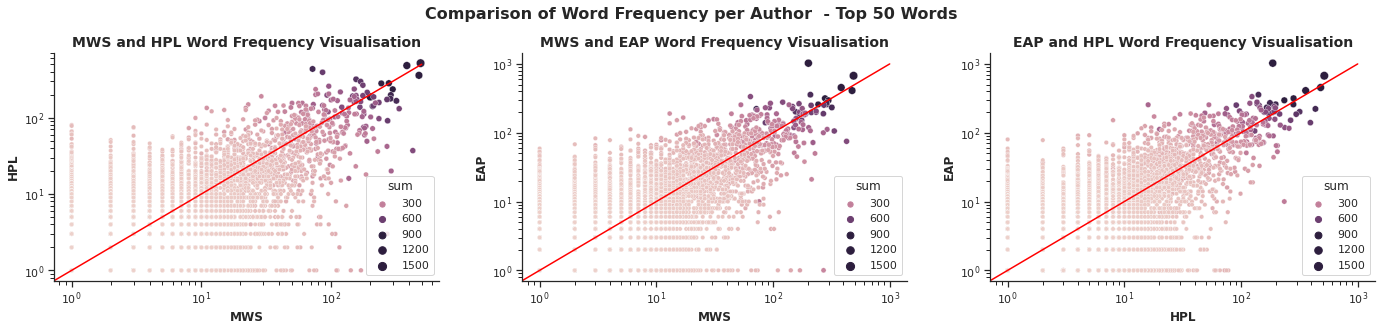

In [18]:
fig, axarr = plt.subplots(1,3, figsize=(20, 5))

ax = sns.scatterplot(x =(freq_wordsDF['MWS']+1), y = (freq_wordsDF['HPL']+1), ax=axarr[0],hue = freq_wordsDF['sum'],hue_norm=(0,800), size = freq_wordsDF['sum'])
axarr[0].plot([0, 500], [0, 500], color = 'red') # Plot the red line that divides the 2 areas.
ax.set(xscale="log", yscale="log")
axarr[0].set_xlabel('MWS',fontsize = 12,weight = 'bold')
axarr[0].set_ylabel('HPL',fontsize = 12,weight = 'bold')
axarr[0].set_title('MWS and HPL Word Frequency Visualisation', fontsize = 14,weight = 'bold');

ax1 = sns.scatterplot(x = freq_wordsDF['MWS']+1, y = freq_wordsDF['EAP']+1, ax=axarr[1],hue = freq_wordsDF['sum'],hue_norm=(0,800), size = freq_wordsDF['sum']) 
ax1.set(xscale="log", yscale="log")
axarr[1].plot([0, 1000], [0, 1000], color = 'red') # Plot the red line that divides the 2 areas
axarr[1].set_xlabel('MWS',fontsize = 12,weight = 'bold')
axarr[1].set_ylabel('EAP',fontsize = 12,weight = 'bold')
axarr[1].set_title('MWS and EAP Word Frequency Visualisation', fontsize = 14,weight = 'bold');

ax2 = sns.scatterplot(x = freq_wordsDF['HPL']+1, y = freq_wordsDF['EAP']+1, ax=axarr[2],hue = freq_wordsDF['sum'],hue_norm=(0,800), size = freq_wordsDF['sum']) 
ax2.set(xscale="log", yscale="log")
axarr[2].plot([0, 1000], [0, 1000], color = 'red') # Plot the red line that divides the 2 areas
axarr[2].set_xlabel('HPL',fontsize = 12,weight = 'bold')
axarr[2].set_ylabel('EAP',fontsize = 12,weight = 'bold')
axarr[2].set_title('EAP and HPL Word Frequency Visualisation', fontsize = 14,weight = 'bold');
sns.despine(top=True, right=True, left=False, bottom=False)

fig.tight_layout(pad=3.0)
plt.suptitle('Comparison of Word Frequency per Author  - Top 50 Words',fontsize=16, weight = 'bold');
plt.show()

* The graphs are plotted in logarithmic scale to better visualise the pattern of words with lower incidence
* A 3D plot is also shown below. However, sometimes a 3D plot is not as helpful as 2D cross-sections
* The plots demonstrate the most common words (darker colour and larger markers) are mostly neutral, near the red line that separate the authors 
* Note the outlier for EAP at the top (2nd and 3rd graphs). This author seems obsessed with the word **upon**, as we saw in the previous plot
* The vertical and horizontal patterns are words that are used by one author and are either 0 or a very low value for the other author. 
* Words that have a lower total count (bright colour) seem to be the ones that are more particular for each author, i.e points that are further from the red line, and present a high value in only one of the axis

In [19]:
import plotly.express as px
fig = px.scatter_3d(x=(freq_wordsDF['MWS']+1), y=(freq_wordsDF['HPL']+1), z=(freq_wordsDF['EAP']+1),
                    opacity=0.9,
                    log_x=True,log_y=True,log_z=True,color=freq_wordsDF["sum"], size=freq_wordsDF["sum"])
#fig.update_traces(marker=dict(size=3))#, selector=dict(type='scatter3d'))

fig.update_layout(title=dict(text = 'Word Frequency by Author - 3D Scatter'), 
                  scene = dict(xaxis_title='MWS',yaxis_title='HPL',zaxis_title='EAP',
                              xaxis = dict(backgroundcolor="rgb(200, 200, 230)"),
                              yaxis = dict(backgroundcolor="rgb(230, 200,230)"),
                              zaxis = dict(backgroundcolor="rgb(230, 230,200)")))

fig.update_traces(hovertemplate='MWS: %{x} <br>HPL: %{y} <br>EAP: %{z}') #
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## 1.4 Co-occurrence Word Pattern

Here we study the relantioship between words. The intent is to understand which words are most commonly used in the same sample. 

The **CountVecorizer** library is used to perform this analysis, and it is defined to extract the top 20 words by setting **max_features = 20**. Adding more features makes it harder to interpret the data. 

A heatmap is used to demonstrate the relationship between the words:

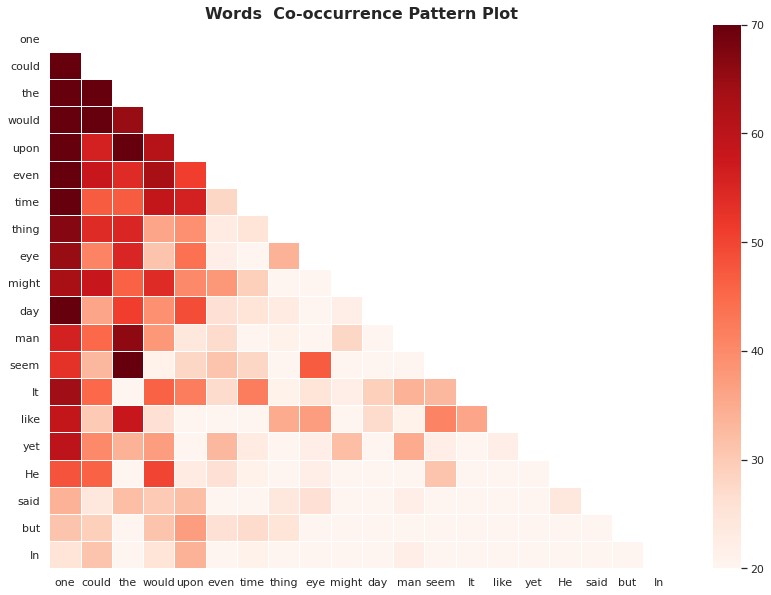

In [20]:
Corpus = df_train['text'].sample(frac=0.6, random_state=1) #extract sample from Dataset, Adding the whole dataset does not change the pattern
Corpus = list(Corpus) #The CountVectorizer needs the inputs as list

count_model = CountVectorizer(preprocessor = preprocess_sentence, max_features = 20) #extracts the top most used words, uses my function to preprocess
CountVectData = count_model.fit_transform(Corpus) #fits and transforms to my corpus
CountVectDatac = (CountVectData.T * CountVectData) # this is co-occurrence matrix in sparse csr format
CountVectDatac.setdiag(0) # fill same word co-occurence as zero, they have much higher numbers than the remaining words

#Create DF
CountVectDF = pd.DataFrame(CountVectDatac.A, columns=count_model.get_feature_names(), index = count_model.get_feature_names()) #creates DF 
hour_count = CountVectDF.sum(axis=1) #Creates a sum column to be used to order entries

sorter = hour_count.sort_values(ascending = False).index #sorter of rows and columns
CountVectDF = CountVectDF[sorter] #sorts columns according to most occurred word
CountVectDF = CountVectDF.reindex(sorter) #sorts rows in the same order as columns

#Plot
mask = np.zeros_like(CountVectDF)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14,10))
    ax = sns.heatmap(CountVectDF, mask=mask, vmax = 70, vmin = 20, linewidths=.8,annot=False,cmap = 'Reds',annot_kws={"size": 10},cbar=True)
plt.title('Words  Co-occurrence Pattern Plot', fontsize = 16,weight = 'bold');    

* By ranking the words according to the number of co-occurrence, the plot created a nice vertical gradient
* There is a clear vertical pattern break from the word **even** and onwards
* The gradient shows that the words co-occur the most are used together most often, i.e. the top three words **could, would, upon** are commonly used with **one** (the most co-occurred word)
* For most words, the peak of occurrence occurs with one of the top four words (**one, could, would, upon**)
* Outlier from this trend are the words **seem** and **look**, which can also be commonly used with **eye** and **like**

Another interesting analysis would be to create the same plot by author or by sentiment analysis class (positive, negative, neutral).

## 1.5 Word Cloud

No text analysis is complete without a word cloud. Here, I created the mask using PowerPoint Icons and saved as PNG image. Just in case is not clear, the image is a pumpkin, a bat and a headstone with Rest in peace (RIP), or from the *Latin*, Requiescat In Pace.

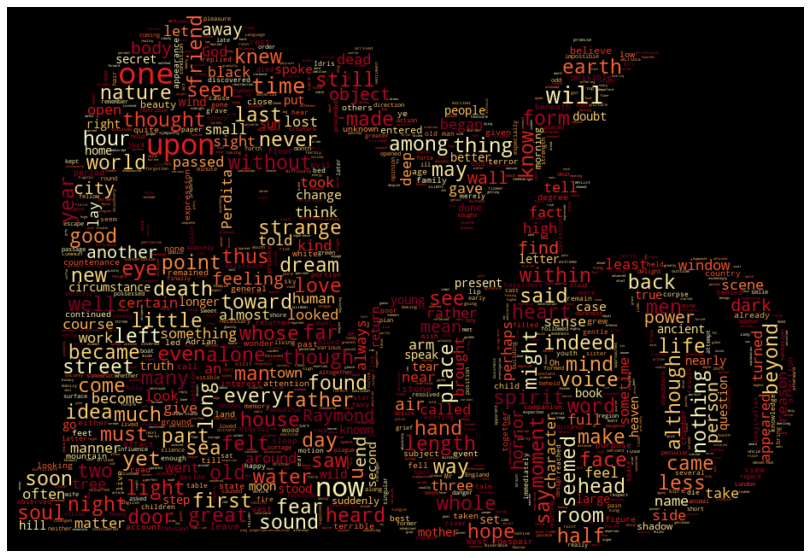

In [21]:
author_mask = np.array(Image.open(urlopen('https://github.com/negrinij/NLP-AuthorsChallenge/blob/main/images/Hallowen1.PNG?raw=true')))
   
wc = WordCloud(background_color="black",contour_width=0.1,colormap = 'YlOrRd',max_words=2000, mask=author_mask,max_font_size=36, random_state=42)
text = " ".join(review for review in df_train.text)
wc.generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2. NLP Model

To build the NLP model, this [notebook](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) has really helped to better understand the NLP process. As mentioned on that Notebook, Kaggle is using a multi-class log-loss as evaluation metric. The LogLoss is a Logarithmic Loss metric, as such, the lower the value the better.

The implementation was taken from [here](https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py):

In [22]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

## 2.1 Data Preprocessing

For the Data Analysis section we played with preprocessing. Now we are going to prepare our dataset for our ML model:
* Encode the Labels
* Pre-Process text samples (stemming, stopwords, lowercase, remove punctuations)
* Oragnise the Training, Validation and Test Sets
* Use CountVectorizes to build the word vector

An additional step that has improved performance was to add the most common words to the **Stop_Words** list. The model improved by removing *one, could, and would* from the samples. In addition, not transforming the words to lowercase also increased model performance.

>Data Preprocessing and Creation of Training and Test Sets

In [23]:
stop_words.update(('one','could','would'))

df_train = pd.read_csv('/kaggle/input/spooky-author-identification/train.zip')
df_test = pd.read_csv('/kaggle/input/spooky-author-identification/test.zip')

df_train['text_pre'] = df_train['text'].apply(lambda x : preprocess_sentence(x))
df_test['text_pre'] = df_test['text'].apply(lambda x : preprocess_sentence(x))

LabelEnc = preprocessing.LabelEncoder()
target_train = LabelEnc.fit_transform(df_train.author.values)
features_train = df_train.text_pre.values

features_test = df_test.text_pre.values

# Create First Train and Test sets
x_train, x_test, y_train, y_test = train_test_split(features_train, target_train, test_size=0.20,random_state=123)

print ("Training set size", x_train.shape[0])
print ("Test set size",x_test.shape[0])

Training set size 15663
Test set size 3916


>Using CountVectorize to transform the data and train our Naive-Bayes and Logistic Regression Models

In [24]:
CVec = CountVectorizer(analyzer='word',ngram_range=(1, 3),dtype=np.float32)

# Fitting Count Vectorizer to training and test sets
x_train_CVec =  CVec.fit_transform(x_train) 
x_test_CVec = CVec.transform(x_test)

submission_test = CVec.transform(features_test)

>I have also tried using TF.IDF to transform the data and train the models. However, CountVectorizer has shown to be the best option for this application

In [25]:
tfidf_vec = TfidfVectorizer(dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)

# Fitting TFIDF to trainingand test sets
x_train_tfidf = tfidf_vec.fit_transform(x_train)
x_test_tfidf = tfidf_vec.transform(x_test)

# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
#svd = decomposition.TruncatedSVD(n_components=200)
#xtrain_svd = svd.fit_transform(x_train_tfidf)
#xtest_svd = svd.transform(x_test_tfidf)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
#Scaler = preprocessing.StandardScaler()
#xtrain_svd_scl = Scaler.fit_transform(xtrain_svd)
#xtest_svd_scl = Scaler.transform(xtest_svd)

The models used for this study are the classic Naive-Bayes (NB) and Logistic Regression (LR), commonly used for NLP tasks. In addition, I am also using LGBM as it usually provides a good trade-off between accuracy and training time.

The model hyperparameters were optimised using the Optuna Library. The code for the optimisation is commented out as it requires a long time for the LGBM and LR.

In [26]:
# The classification Models
LR = LogisticRegression(C=1, solver = 'lbfgs', max_iter = 1000)
NB = MultinomialNB(alpha = 1.3)
clf_LGBM = lgbm.LGBMClassifier(objective='multiclass',
                               metric = 'multi_logloss',
                               verbose=-1, 
                               learning_rate=0.08, 
                               max_depth=87, 
                               num_leaves=91, 
                               early_stopping_round = 100, 
                               n_estimators = 10000,
                               reg_alpha = 0.0003,
                               reg_lambda = 0.02897)

We validate the models using a K-Fold strategy. Five folds were selected as this ratio provides a good balance between training and validation sets. For the cross-validation, approximately 12.000 samples are used for training and 3.000 for validation for each fold. The mean LogLoss for the five folds and the Standard Deviation are recorded for model evaluation. Ideally, the CV result and the separate Test set scores should be similar as an indication that the model is not overfitting.

In [27]:
kf = KFold(n_splits=5, shuffle = True, random_state = 123)

def CV(model,x_train,x_test):
    logloss = []
    for train_index, test_index in kf.split(x_train):
            X_train, X_val = x_train[train_index], x_train[test_index]
            Y_train, Y_val = y_train[train_index], y_train[test_index]        
            model.fit(X_train, Y_train)
            predictions = model.predict_proba(X_val)
            logloss.append(multiclass_logloss(Y_val, predictions))
    test_score = multiclass_logloss(y_test, model.predict_proba(x_test))
    mean_res = np.mean(logloss)
    std_dev = np.std(logloss)
    return mean_res,std_dev, test_score, model    

def CV_LGBM(model,x_train,x_test):
    logloss = []
    for train_index, test_index in kf.split(x_train):
            X_train, X_val = x_train[train_index], x_train[test_index]
            Y_train, Y_val = y_train[train_index], y_train[test_index]
            model.fit(X_train, Y_train, eval_metric='multi_logloss', eval_set=[(X_val, Y_val)],verbose=0)
            predictions = model.predict_proba(X_val)
            logloss.append(multiclass_logloss(Y_val, predictions))
    test_score = multiclass_logloss(y_test, model.predict_proba(x_test))
    mean_res = np.mean(logloss)
    std_dev = np.std(logloss)
    return mean_res,std_dev,test_score,model  

LR_Model = CV(LR,x_train_CVec,x_test_CVec)
NB_Model = CV(NB,x_train_CVec,x_test_CVec)
LGBM_Model = CV_LGBM(clf_LGBM,x_train_CVec,x_test_CVec)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



An additional ensemble model is created to verify if such strategy could provide any significant improvement to our model. The sklearn library provides the VotingClassifier module to facilitate the ensemble model construction.

In [28]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('LR', LR), ('NB', NB)], voting='soft', weights=[1,1.5])
Ensemble_Model = CV(ensemble,x_train_CVec,x_test_CVec)

In [29]:
def create_model(trial):
    #regularization = trial.suggest_loguniform('logistic-regularization', 0.0001, 1)
    #lr_solver = trial.suggest_categorical('solver', ["sag", "saga",'lbfgs'])
    #model = LogisticRegression( C=regularization, solver='lbfgs', max_iter = 100)#,intercept_scaling = lr_intercept_scaling)
    
    #NBAlpha = trial.suggest_loguniform('logistic-regularization', 0.0001, 1)
    #model = MultinomialNB(alpha = NBAlpha)
    
    #LGBM_alpha = trial.suggest_loguniform('LGBM_alpha', 0.0001, 1)
    #LGBM_lambda = trial.suggest_loguniform('LGBM_lambda', 0.0001, 1)
    LGBM_num_leaves = trial.suggest_int('LGBM_num_leaves', 5, 500)
    LGBM_max_depth = trial.suggest_int('LGBM_max_depth', 5, 500)
    LGBM_LR = trial.suggest_loguniform('LGBM_LR', 0.01, 0.1)
    #LGBM_estimators = trial.suggest_int('LGBM_estimators', 50, 10000)
    
    model = lgbm.LGBMClassifier(objective = 'multiclass',
                           metric = 'multi_logloss',
                           learning_rate = LGBM_LR,
                           early_stopping_round = 50,
                           n_estimators = 10000,
                           max_depth=LGBM_max_depth, num_leaves=LGBM_num_leaves,reg_alpha = 0.0003,reg_lambda = 0.02897,verbose = -1)  
    
    if trial.should_prune():
            raise optuna.TrialPruned()
    return model

def objective(trial):
    model = create_model(trial)
    accuracy,_,_,_ = CV_LGBM(clf_LGBM,x_train_CVec,x_test_CVec)
    # Save a trained model to a file.
    with open("{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    return accuracy

#study = optuna.create_study(direction="minimize");
#study.optimize(objective, n_trials=10);
#print("Mean of Cross-Validation Sets: %.4f"% (study.best_value))
#print("The best parameters are: ", (study.best_params))

# 3. Result

Here we discuss the results from the modelling strategy we applied. The print statement below show us the LogLoss for each model for the Cross-Validation and Test sets.

In [30]:
print("Logistic Regression \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.3f" % (LR_Model[0],LR_Model[1],LR_Model[2]))
print("Naive-Bayes \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.4f" % (NB_Model[0],NB_Model[1],NB_Model[2]))
print("LGBM \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.3f" % (LGBM_Model[0],LGBM_Model[1],LGBM_Model[2]))
print("Ensemble NB and LR \n LogLoss: %.3f +/- %.4f \n Test Set LogLoss: %.3f" % (Ensemble_Model[0],Ensemble_Model[1],Ensemble_Model[2]))

Logistic Regression 
 LogLoss: 0.527 +/- 0.0105 
 Test Set LogLoss: 0.518
Naive-Bayes 
 LogLoss: 0.464 +/- 0.0145 
 Test Set LogLoss: 0.4897
LGBM 
 LogLoss: 0.594 +/- 0.0109 
 Test Set LogLoss: 0.599
Ensemble NB and LR 
 LogLoss: 0.431 +/- 0.0110 
 Test Set LogLoss: 0.434


* Logistic Regression and Naive-Bayes outperformed LGBM by almost a decimal point
* The Ensemble Model has improved the result considerably, showing a smaller LogLoss and also reducing the Standard Deviation between the validation sets
* As LGBM has shown the worse result, it will not be considered for further Error Analysis

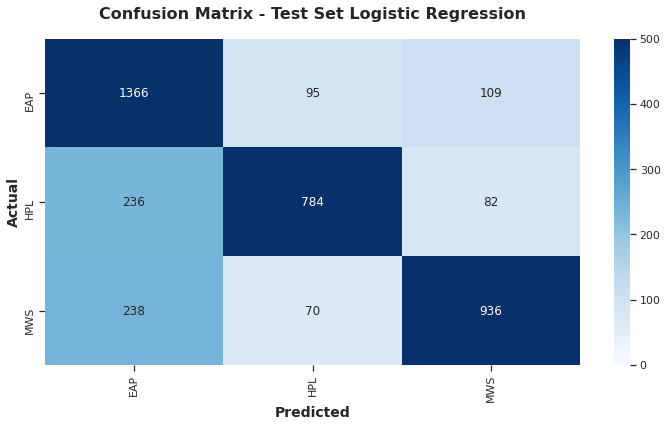

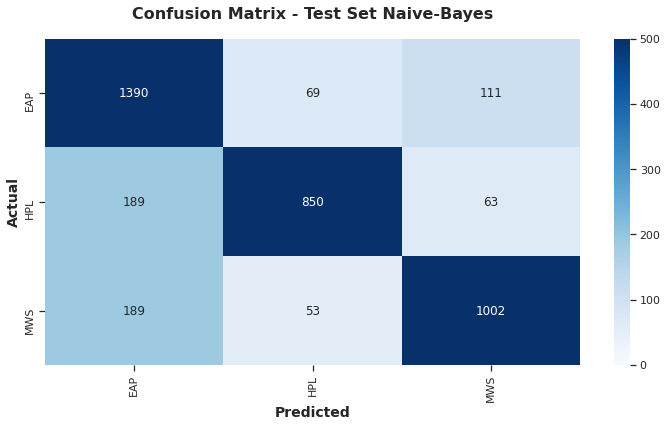

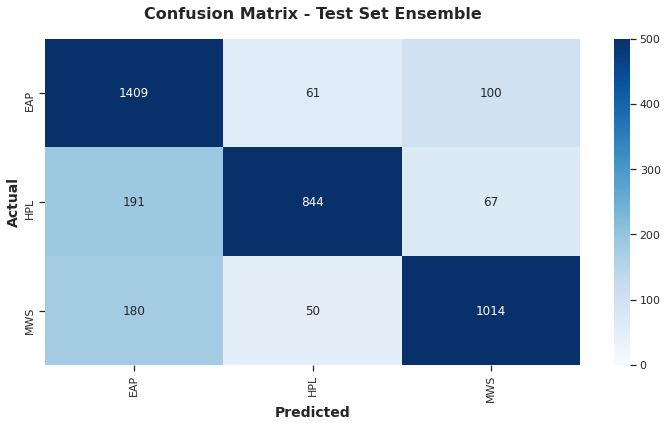

In [31]:
LR_preds = LR_Model[3].predict(x_test_CVec)
NB_preds = NB_Model[3].predict(x_test_CVec)
Ensemble_preds = Ensemble_Model[3].predict(x_test_CVec)

categories = ['EAP', 'HPL','MWS']

def CMatrix(predictions, title):
    CMatrix = pd.DataFrame(confusion_matrix(y_test, predictions), columns=categories, index =categories)

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 500,cmap = 'Blues')
    ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
    ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
    ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
    ax.set_title('Confusion Matrix - Test Set ' + title,fontsize = 16,weight = 'bold',pad=20);

CMatrix(LR_preds,'Logistic Regression')
CMatrix(NB_preds,'Naive-Bayes')
CMatrix(Ensemble_preds,'Ensemble')

* EAP is most often misclassified as MWS than HPL, this trend is seen on all three ML models
* In a similar manner, HPL is most often misclassified as EAP
* MWS samples also present higher number of samples misclassified as EAP
* All three ML models present the same pattern of misclassifications, i.e. HPL and MWS samples being misclassified as EAP
* The Ensemble Model presents a higher number of TP for MWS and EAP and reduced the TP for HPL

The code below is to prepare the CSV file for submission. Since the competition is no longer open, only manual submission is allowed. 

In [32]:
ensemble_preds = Ensemble_Model[3].predict_proba(submission_test)
ids = df_test['id']
predict = pd.DataFrame(ensemble_preds, columns=['EAP','HPL','MWS'])
submission = pd.concat([ids, predict] ,axis = 1)
submission.to_csv('submission.csv',index=False)

# 4. Conclusion

As final remarks, it was quite surprising that Logistic Regression and Naive-Bayes have outperformed the LGBM model. Perhaps more effort into the hyperparameter optimisation could improve the LGBM model, but I am not sure if it would overcome the results for NB. As most Data Science problems, great improvements can be achieved by better understanding the data and where the model is finding difficulties. 

As the next step, it would be advised to individually analyse the samples our model are mislabelling and see if there are any hints. Perhaps, shorter samples are more challenging or specific words could be removed to improve our model. In addition, other steps of the text preprocessing (such as removing symbols and punctuation) could be harming the prediction performance. Balancing the samples could be beneficial to increase the prediction performance for MWS and HPL.

## I hope you enjoyed this notebook as it is my initial insight into NLP. Any suggestions or corrections are welcome. 